In [1]:
import os

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image

from tqdm.notebook import tqdm_notebook

import utils

In [2]:
def cov_n_inv(sigma_inv: np.ndarray, sigma_0_inv:np.ndarray, n: int):
    return n * sigma_inv + sigma_0_inv 

In [3]:
def mu_n(sample_mean, prior_mu0, sample_cov, prior_sigma0, n: int, a_inv: np.ndarray):
    """
    a_inv = np.linalg.inv(Sigma_0 + Sigma / n)
    """

    # (64,64) @ (64,64) @ (64, 1) + (64, 64) @ (64, 64) @ (64, 1) -> (64, 1) + (64,1)
    return prior_sigma0 @ a_inv @ sample_mean + sample_cov @ a_inv @ prior_mu0 / n

In [4]:
def sigma_n(sigma, sigma_0, n: int, a_inv: np.ndarray):
    return sigma_0 @ a_inv * sigma / n

In [5]:
def g(x, W, w, w0):
    """
    Decision boundary function g_i(x).
    """
    return x.T @ W @ x + w.T @ x + w0

## Load Data

In [6]:
current_dir = os.getcwd() 
data_dir = os.path.join(current_dir, "data")
prior1_fname = os.path.join(data_dir, "Prior_1.mat")
prior2_fname = os.path.join(data_dir, "Prior_2.mat")
alpha_fname = os.path.join(data_dir, "Alpha.mat")

mat_fname = os.path.join(data_dir, "TrainingSamplesDCT_8_new.mat")
mat_fname_subset = os.path.join(data_dir, "TrainingSamplesDCT_subsets_8.mat")
plot_dir = os.path.join(current_dir, "plots")

# Create the directory if it does not exist
for d in [data_dir, plot_dir]:
    if not os.path.exists(d):
        os.mkdir(d)
        
   

In [7]:
# Load the data

subsets8 = sio.loadmat(mat_fname_subset)
prior_1 = sio.loadmat(prior1_fname)
prior_2 = sio.loadmat(prior2_fname)
alpha_dict = sio.loadmat(alpha_fname)

alpha = alpha_dict['alpha']

D1_BG = subsets8['D1_BG']
D1_FG = subsets8['D1_FG']

## a) Bayesian Estimation
Consider the training set D1 and strategy 1,

 For each class, compute the covariance $\Sigma$ of the class-conditional, and the posterior mean $\mu_1$ , and covariance $\Sigma_1$ of

 $$ P_{\mu|T}(\mu|D1) = N (\mu, \mu1, \Sigma_1) $$

In [8]:
n_BG = D1_BG.shape[0]
n_FG = D1_FG.shape[0]
print(f"num_BG: {n_BG}") 
print(f"num_FG: {n_FG}")

num_BG: 300
num_FG: 75


In [9]:
P_FG = n_FG / (n_FG + n_BG)
P_BG = n_BG / (n_FG + n_BG)
print(f"prior_FG: {P_FG}")
print(f"prior_BG: {P_BG}")

prior_FG: 0.2
prior_BG: 0.8


$$ p(x|\mu) \sim N(\mu, \Sigma) $$
$$ p(\mu) \sim N (\mu_0, \Sigma_0) $$
where $\Sigma$, $\Sigma_1$ and $\mu_0$ are assumed to be known.

$$\mu_n = \Sigma_{0} \big(\Sigma_{0} + \frac{1}{n}\Sigma\big)^{-1} \hat{\mu_{n}} + \frac{1}{n}\Sigma \big(\Sigma_0 + \frac{1}{n}\Sigma \big)^{-1} \mu_{0}$$

Where $\hat{\mu_{n}}$ is the sample mean$
$$\hat{\mu_n} = \frac{1}{n} \sum_{k=1}^{n} x_k$$

$$ \Sigma_{n}^{-1} = n \Sigma^{-1} + \Sigma_{0}^{-1} $$
$$ \Longrightarrow \Sigma_n = \Sigma_0 \big(\Sigma_0 + \frac{1}{n}\Sigma \big)^{-1} \frac{1}{n}\Sigma$$ 


Since the sum of two independent, normally distibuted vectors is again a normally distributed vector. 

whose mean is the sum of the means 

and whose covariance matrixis is the sum of the covariance matrices
$$ p(x|D) \sim N(\mu_n, \Sigma + \Sigma_n) $$

In [10]:
# \mu_0
prior1_mu0_BG = prior_1['mu0_BG'].reshape(-1, 1)
prior1_mu0_FG = prior_1['mu0_FG'].reshape(-1, 1)

In [11]:
# \hat{\mu_n} sample mean
D1_BG_mean = np.mean(D1_BG, axis=0).reshape(-1, 1)
D1_FG_mean = np.mean(D1_FG, axis=0).reshape(-1, 1)


In [12]:
# Sigma
D1_cov_BG = np.cov(D1_BG.T, bias=False)
D1_cov_FG = np.cov(D1_FG.T, bias=False)


For the covariance $\Sigma_0$, we assume a diagonal matrix with $$(\Sigma_0)_{ii} = \alpha \omega_i$$

In [13]:
# load Image (original_img has dtype=uint8)
img = np.asarray(Image.open(os.path.join(data_dir, "cheetah.bmp"), "r"))

# Convert to double and / 255
img = utils.im2double(img)
# (255, 270)
# plt.imshow(img)
# plt.show()
assert img.min() == 0 and img.max() <= 1

In [14]:
ground_truth = np.asarray(Image.open(os.path.join(data_dir, "cheetah_mask.bmp"), "r"))
# plt.imshow(ground_truth)
# plt.title("Ground Truth")
# plt.show()

In [15]:
logp_FG = np.log(P_FG)
logp_BG = np.log(P_BG)

In [16]:
img_lst = []
alpha = alpha.ravel()
old_prior_sigma_0 = np.zeros((64, 64))
for a in tqdm_notebook(range(alpha.shape[0])):
    
    processed_img = np.empty([img.shape[0] - 8, img.shape[1] - 8], dtype=bool)
    
    # Sigma_0 (with weight = alpha[i] )
    prior_sigma_0 = np.diag((alpha[a] *  prior_1["W0"]).flat)
    assert prior_sigma_0.shape[0] == 64 and prior_sigma_0.shape[1] == 64
    assert not np.allclose(old_prior_sigma_0, prior_sigma_0)
    old_prior_sigma_0 = prior_sigma_0
    
    # * pre-compute the inverse of Sigma_0 + (Sigma / n)
    a_BG = prior_sigma_0 + D1_cov_BG / n_BG
    a_FG = prior_sigma_0 + D1_cov_FG / n_FG
    
    a_BG_inv = np.linalg.inv(a_BG)
    a_FG_inv = np.linalg.inv(a_FG)
    
    
    # Parameter Distribution
    mu_n_BG = mu_n(D1_BG_mean, prior1_mu0_BG, D1_cov_BG, prior_sigma_0, n_BG, a_BG_inv)
    mu_n_FG = mu_n(D1_FG_mean, prior1_mu0_FG, D1_cov_FG, prior_sigma_0, n_FG, a_FG_inv)
    
    cov_n_BG = sigma_n(D1_cov_BG, prior_sigma_0, n_BG, a_BG_inv)
    cov_n_FG = sigma_n(D1_cov_FG, prior_sigma_0, n_FG, a_FG_inv)
    
    
    # Sum of independent gaussian
    mu_BG = mu_n_BG
    mu_FG = mu_n_FG
    
    cov_BG = cov_n_BG + D1_cov_BG 
    cov_FG = cov_n_FG + D1_cov_FG
    
    # guassian decsison bounday
    logdet_BG = np.log(np.linalg.det(cov_BG))
    logdet_FG = np.log(np.linalg.det(cov_FG))
    
    W_BG = np.linalg.inv(cov_BG)
    W_FG = np.linalg.inv(cov_FG)
    
    w_BG = -2 * W_BG @ mu_BG
    w_FG = -2 * W_FG @ mu_FG
    
    w0_FG = mu_FG.T @ W_FG @ mu_FG + logdet_FG - 2 * logp_FG
    w0_BG = mu_BG.T @ W_BG @ mu_BG + logdet_BG - 2 * logp_BG
    
    # Feature vector 64 x 1
    x_64 = np.zeros((64, 1), dtype=np.float64)
    for i in (range(processed_img.shape[0])):
        for j in range(processed_img.shape[1]):
            # # 8 x 8 block
            block = img[i : i + 8, j : j + 8]
            # DCT transform on the block
            block_DCT = utils.dct2(block)
            # zigzag pattern mapping
            for k in range(block_DCT.shape[0]):
                for p in range(block_DCT.shape[1]):
                    loc = utils.zigzag[k, p]
                    x_64[loc, :] = block_DCT[k, p]
            
            if g(x_64, W_FG, w_FG, w0_FG) > g(x_64, W_BG, w_BG, w0_BG):
                processed_img[i, j] = 0  
            else:
                processed_img[i, j] = 1    
    img_lst.append(processed_img)


  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
error_lst_bayes = [utils.calculate_error(img, ground_truth, verbose=False)[0] for img in img_lst]

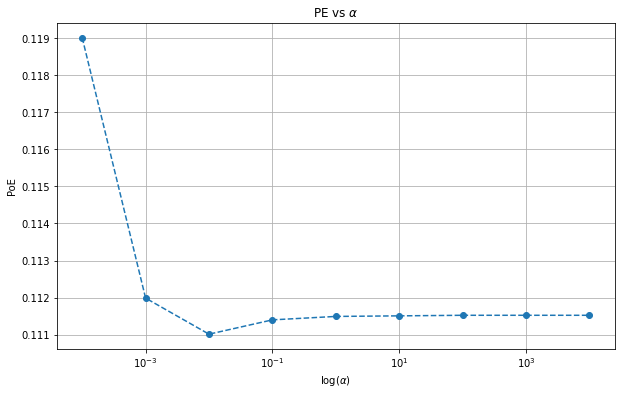

In [18]:
plt.figure(figsize=(10, 6))
plt.plot((alpha.flat), error_lst_bayes, "--o", label="Error")
plt.xscale("log")
plt.xlabel(r"$\log (\alpha)$")
plt.ylabel("PoE")
plt.grid()
plt.title(r"PE vs $\alpha$")
plt.show()

## b) MLE

In [19]:
def ML_result():
    TrainsampleDCT_BG = subsets8['D1_BG']
    TrainsampleDCT_FG = subsets8['D1_FG']
    
    m_FG_ML, n_FG = TrainsampleDCT_FG.shape
    m_BG_ML, n_BG = TrainsampleDCT_BG.shape

    P_FG_ML = m_FG_ML / (m_FG_ML + m_BG_ML)
    P_BG_ML = m_BG_ML / (m_FG_ML + m_BG_ML)
    assert P_FG_ML + P_BG_ML == 1

    # =======================================================================================
    # ML mean mu
    mu_FG_ML = np.mean(TrainsampleDCT_FG, axis=0).reshape(-1, 1)
    mu_BG_ML = np.mean(TrainsampleDCT_BG, axis=0).reshape(-1, 1)
    
    # ML covariance Sigma
    cov_FG_ML, cov_BG_ML = np.cov(TrainsampleDCT_FG.T), np.cov(TrainsampleDCT_BG.T)
    
    img = np.asarray(Image.open(os.path.join(data_dir, "cheetah.bmp"), "r"))
    
    # Convert to double and / 255
    img = utils.im2double(img)
    assert img.min() == 0 and img.max() <= 1
    
    ground_truth = np.asarray(Image.open(os.path.join(data_dir, "cheetah_mask.bmp"), "r"))

    processed_img = np.zeros([img.shape[0] - 8, img.shape[1] - 8], dtype=bool)
    
    # constants
    
    logp_FG_ML = np.log(P_FG_ML)
    logp_BG_ML = np.log(P_BG_ML)
    
        
    logdet_FG_ML = np.log(np.linalg.det(cov_FG_ML))
    logdet_BG_ML = np.log(np.linalg.det(cov_BG_ML))
    
    W_FG = np.linalg.inv(cov_FG_ML)
    W_BG = np.linalg.inv(cov_BG_ML)
    
    w_FG = -2 * W_FG @ mu_FG_ML
    w_BG = -2 * W_BG @ mu_BG_ML
    
    w0_FG = mu_FG_ML.T @ W_FG @ mu_FG_ML + logdet_FG_ML - 2 * logp_FG_ML
    w0_BG = mu_BG_ML.T @ W_BG @ mu_BG_ML + logdet_BG_ML - 2 * logp_BG_ML


    # Feature vector 64 x 1
    x_64 = np.zeros((64, 1), dtype=np.float64)
    for i in (range(processed_img.shape[0])):
        for j in range(processed_img.shape[1]):
            # 8 x 8 block
            block = img[i : i + 8, j : j + 8]
            # DCT transform on the block
            block_DCT = utils.dct2(block)
            # zigzag pattern mapping
            for k in range(block_DCT.shape[0]):
                for p in range(block_DCT.shape[1]):
                    loc = utils.zigzag[k, p]
                    x_64[loc, :] = block_DCT[k, p]
            
            if g(x_64, W_FG, w_FG, w0_FG) >= g(x_64, W_BG, w_BG, w0_BG):
                processed_img[i, j] = 0  
            else:
                processed_img[i, j] = 1
    errors_ML = utils.calculate_error(processed_img, ground_truth)
    return errors_ML

In [20]:
ML_error, _, _, = ML_result()

The probability of error: 0.15650400222517535
FG error: 0.1466606916586828
BG error is: 0.009843310566492567


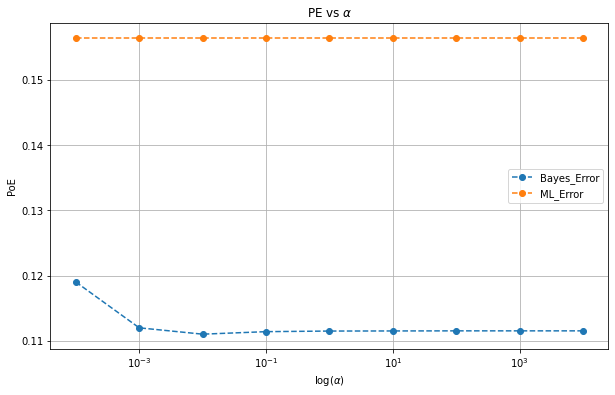

In [22]:
plt.figure(figsize=(10, 6))
plt.plot((alpha.flat), error_lst_bayes, "--o", label="Bayes_Error")
plt.plot((alpha.flat), [ML_error]*9, "--o", label="ML_Error")
plt.xlabel(r"$\log (\alpha)$")
plt.ylabel("PoE")
plt.xscale("log")
plt.grid()
plt.title(r"PE vs $\alpha$")
plt.legend()
plt.show()

## c) MAP estimate of $\mu$

$$ P_{X|T}(x|D1) = P_{X|\mu}(x|\mu_{MAP})$$

where
$$ \mu_{MAP} = \argmax_{\mu} P_{\mu|T}(\mu|D1) \\ = \argmax_{\theta} P_{T|\mu}(D1|\mu)P_{\Theta}(\theta)$$


In [23]:
img_lst_MAP = []
for a in tqdm_notebook(range(alpha.shape[0])):
    
    processed_img = np.empty([img.shape[0] - 8, img.shape[1] - 8], dtype=bool)
    
    # Sigma_0 (with alpha[:, i])
    prior_sigma_0 = np.diag((alpha[a] *  prior_1["W0"]).flat)
    assert prior_sigma_0.shape[0] == 64 and prior_sigma_0.shape[1] == 64
    
    # * pre-compute the inverse of Sigma_0 + Sigma / n
    a_BG = prior_sigma_0 + D1_cov_BG / n_BG
    a_FG = prior_sigma_0 + D1_cov_FG / n_FG
    
    a_BG_inv = np.linalg.inv(a_BG)
    a_FG_inv = np.linalg.inv(a_FG)
    
    
    # Parameter Distribution
    mu_n_BG = mu_n(D1_BG_mean, prior1_mu0_BG, D1_cov_BG, prior_sigma_0, n_BG, a_BG_inv)
    mu_n_FG = mu_n(D1_FG_mean, prior1_mu0_FG, D1_cov_FG, prior_sigma_0, n_FG, a_FG_inv)
    
    cov_n_BG = sigma_n(D1_cov_BG, prior_sigma_0, n_BG, a_BG_inv)
    cov_n_FG = sigma_n(D1_cov_FG, prior_sigma_0, n_FG, a_FG_inv)
    
    
    # Sum of independent gaussian -- MAP
    mu_BG = mu_n_BG
    mu_FG = mu_n_FG
    
    cov_BG = D1_cov_BG
    cov_FG = D1_cov_FG
    # =========================================================================================
    # guassian decsison bounday
    logdet_BG = np.log(np.linalg.det(cov_BG))
    logdet_FG = np.log(np.linalg.det(cov_FG))
    
    W_BG = np.linalg.inv(cov_BG)
    W_FG = np.linalg.inv(cov_FG)
    
    w_BG = -2 * W_BG @ mu_BG
    w_FG = -2 * W_FG @ mu_FG
    
    w0_FG = mu_FG.T @ W_FG @ mu_FG + logdet_FG - 2 * logp_FG
    w0_BG = mu_BG.T @ W_BG @ mu_BG + logdet_BG - 2 * logp_BG
    
    # Feature vector 64 x 1
    x_64 = np.zeros((64, 1), dtype=np.float64)
    for i in (range(processed_img.shape[0])):
        for j in range(processed_img.shape[1]):
            # # 8 x 8 block
            block = img[i : i + 8, j : j + 8]
            # DCT transform on the block
            block_DCT = utils.dct2(block)
            # zigzag pattern mapping
            for k in range(block_DCT.shape[0]):
                for p in range(block_DCT.shape[1]):
                    loc = utils.zigzag[k, p]
                    x_64[loc, :] = block_DCT[k, p]
            
            if g(x_64, W_FG, w_FG, w0_FG) >= g(x_64, W_BG, w_BG, w0_BG):
                processed_img[i, j] = 0  
            else:
                processed_img[i, j] = 1    
    img_lst_MAP.append(processed_img)

  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
error_lst_MAP = [utils.calculate_error(img, ground_truth, verbose=False)[0] for img in img_lst_MAP]


The MAP error curve starts at lower error. This is due to the prior is good. Then it increases and eventually becomes a horizontal curve and converge to ML error. 


As $\alpha$ increase, the prior information has less effect on $\mu_{MAP}$, the $\mu_{MAP}$ nearly equals to the $\mu_{ML}$ over the sample data.

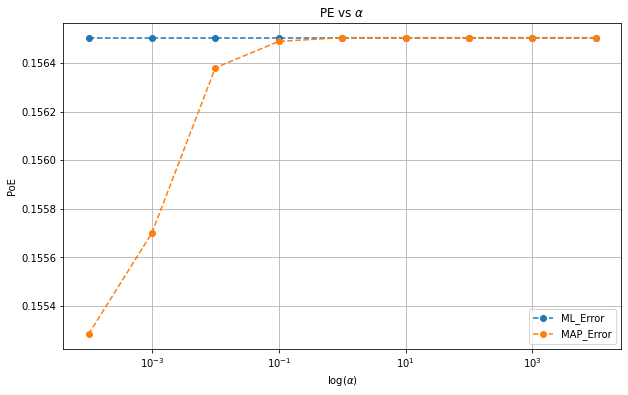

In [25]:
plt.figure(figsize=(10, 6))
# plt.plot((alpha.flat), error_lst, "--o", label="Bayes_Error")
plt.plot((alpha.flat), [ML_error]*9, "--o", label="ML_Error")
plt.plot((alpha.flat), error_lst_MAP, "--o", label="MAP_Error")

plt.xlabel(r"$\log (\alpha)$")
plt.ylabel("PoE")
plt.xscale("log")
plt.grid()
plt.title(r"PE vs $\alpha$")
plt.legend()
plt.show()
